2D AND 3D SIMULATION OF MID-ENERGY PHOTONS PROPAGATION THROUGH MATTER
------------------------------------

---------------------------------------

In [1]:
"""
Building the code for simulating photon propagation in a medium.
We will consider rtg photons with energies in range 10keV-10 MeV.
Main interactions are:
- Compton scattering
- Pair production
- Rayleigh scattering
- Photoelectric effect
We will work in cuboid geometry.
Main tasks:
- Define the medium properties (density, atomic number, etc.)
- Define the photon source (energy spectrum, position, direction)
- Provide the data for the interaction models (cross-sections, etc.)
- Implement the interaction models for each process (eg. Compton scattering - energy loss, angle of scattering)
- Simulate the photon propagation through the medium
"""

print("Photon Propagation Simulation in a Medium")
print("---------------Lets do it!----------------")

Photon Propagation Simulation in a Medium
---------------Lets do it!----------------


import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.optimize import curve_fit
import sympy as sym

#import scipy as sc
#import pandas as pd

import numpy.random as rndm
from numpy.random import uniform as UNFM
#from numpy.random import randint 
#from matplotlib.animation import FuncAnimation

import time

import scienceplots
plt.style.use(['science','notebook','grid'])


# This is just build code
 * some segments are driven deeper
 * for ploting, understanding things better etc.

---
---
---
---
---
---
# 1. Transform direction vector after Compton scattering



* leave all code behind, was just suffering, only paste end code here
* author (source): Studen, ZF

In [ ]:
def SphericalToCartesian(theta, phi):
    x = np.cos(theta)
    y = np.sin(theta) * np.cos(phi)
    z = np.sin(theta) * np.sin(phi)
    return np.array([x, y, z])

def NewDirectionUnitVector(u_old, theta_sc, phi_sc):
    u_old = u_old / np.linalg.norm(u_old) # necessary?
    u_sc_local = SphericalToCartesian(theta_sc, phi_sc)
    # if direction before scattering is close to initial direction of the beam, simple transform
    if np.allclose(u_old, [1, 0, 0]):
        return u_sc_local
    ref_vec = np.array([1, 0, 0])
    v = np.cross(ref_vec, u_old)
    v /= np.linalg.norm(v) # necessary?
    w = np.cross(u_old, v)
    R = np.column_stack((u_old, v, w))
    u_new = R @ u_sc_local
    u_new /= np.linalg.norm(u_new)
    return u_new

---
---
# 2. Compton Scattering event
* generate with help of Geant4 method
* [LINK](https://geant4.web.cern.ch/documentation/pipelines/master/prm_html/PhysicsReferenceManual/electromagnetic/gamma_incident/compton/compton.html) to Geant4 energy drawing
* ...

---
---
* ### using method called combined composition and rejection MC method for RNG for K-N Compton energy PDF !!!


In [55]:
def ComptonEnergyGenerator(E):
    """
    E - energy of the incident photon (MeV)
    E_scattered - energy of the scattered photon (MeV)
    """
    # Define the mass of the electron in MeV/c^2
    m_e = 0.511  # MeV/c^2
    # alpha = E/m_e  # Calculate the alpha parameter for Compton scattering
    alpha = E / m_e 
    # Es = Egamma after scattering; eps = Es/E; eps_min = minimal energy of scattered photon
    eps_min = 1 / (1 + 2 * alpha)  # Minimum energy of the scattered photon
    # eps_max = 1
    beta1 = - np.log(eps_min)
    beta2 = 0.5 * (1 -eps_min**2)

    # Loop to find the scattered energy  - using combined composition and rejection MC method for RNG for K-N Compton energy PDF
    while True:
        # finding the proposed energy of the scattered photon
        r1,r2,r3 = np.random.uniform(0, 1, 3)  # Generate random numbers for the scattering angle
        if r1 < beta1 / (beta1 + beta2):
            ### here, total chaos, i dont know what to use??
            eps_prop = eps_min**r2  # geant4 page
            #eps_prop = eps_min * np.exp(beta2*r2) # Studen 2024
            #eps_prop = eps_min * np.exp((beta1+beta2)*r2-beta1)  # Studen 2020
        else:
            eps_prop = np.sqrt(eps_min**2 + (1- eps_min**2) * r2) # Geant4, Stuedn 2024
            #eps = np.sqrt(eps_min**2 + 2*r2*(beta1+beta2))  # Studen 2020
        # compare g(eps) with r3
        t = (1 - eps_prop) / alpha/ eps_prop
        g_eps = 1 - eps_prop *t*(2-t)/(1+eps_prop**2)
        # accepting the proposed energy of the scattered photon under the condition
        if g_eps > r3:
            eps = eps_prop
            #print("eps =", eps)
            break

    # Calculate the energy, scattering angles and post-interaction direction of the scattered photon
    E_scattered = E * eps  # MeV
    theta_cs = np.arccos(1 - 1/alpha*(1/eps-1)) # Scattering angle in radians
    
    return eps,theta_cs
    # return {
    #     'E_scattered': E_scattered,
    #     'E_electron': E - E_scattered,  # Energy of the recoiled electron
    #     'theta_cs': theta_cs,
    # }

# test the ComptonEnergyGenerator function
E = 1.0  # MeV
eps, theta_cs = ComptonEnergyGenerator(E)
print("eps =", eps)
print("theta_cs =", theta_cs)


eps = 0.4176124112217564
theta_cs = 1.2793087571729784


### Test E' generation
* many generated scattering
* plot PDF
* compare to Klein-Nishina

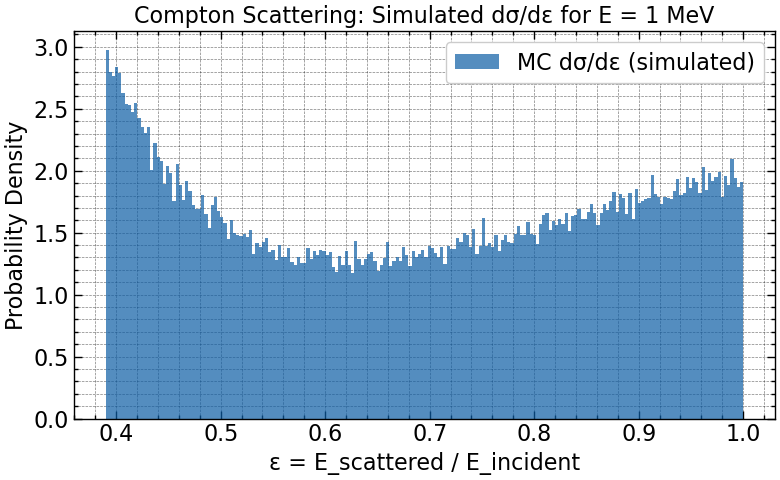

C:\Users\Admin\AppData\Local\Temp\ipykernel_3732\5347191.py:28: RuntimeWarning: invalid value encountered in arccos
  th = np.arccos(1 - 1/alpha*(1/eps-1))  # Scattering angle in radians


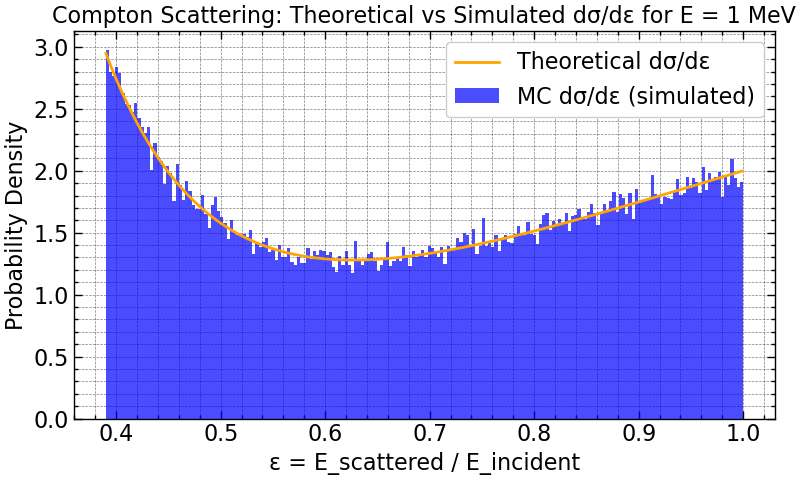

In [58]:
# Test the ComptonEnergyGenerator for E = 1 MeV
E = 0.4  # MeV
Ncs = 10**5  # Number of events

eps_samples = []
theta_cs_samples = []
for _ in range(Ncs):
    eps, th = ComptonEnergyGenerator(E)
    eps_samples.append(eps)
    theta_cs_samples.append(th)

eps_samples = np.array(eps_samples)
theta_cs_samples = np.array(theta_cs_samples)
E_scattered_samples = eps_samples * E

# Plot histogram of eps (normalized to probability density)
plt.figure(figsize=(8,5))
plt.hist(eps_samples, bins=200, density=True, alpha=0.7, label='MC dσ/dε (simulated)')
plt.xlabel('ε = E_scattered / E_incident')
plt.ylabel('Probability Density')
plt.title('Compton Scattering: Simulated dσ/dε for E = 1 MeV')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

def dsdeps(eps,alpha=1.0):
    th = np.arccos(1 - 1/alpha*(1/eps-1))  # Scattering angle in radians
    t = (1 - eps) / alpha / eps
    g_eps = 1 - eps * t * (2 - t) / (1 + eps**2)

    return 1/eps + eps - np.sin(th)**2

# Plot the theoretical dσ/dε for Compton scattering
eps_values = np.linspace(0.01, 0.999, 1000)  # Avoid division by zero
F = 1
dsdeps_values = dsdeps(eps_values,alpha=E / 0.511) * F # E = 1 MeV, m_e = 0.511 MeV/c^2
plt.figure(figsize=(8,5))
plt.plot(eps_values, dsdeps_values, label='Theoretical dσ/dε', color='orange')
plt.hist(eps_samples, bins=200, density=True, alpha=0.7, label='MC dσ/dε (simulated)', color='blue')
plt.xlabel('ε = E_scattered / E_incident')
plt.ylabel('Probability Density')
plt.title('Compton Scattering: Theoretical vs Simulated dσ/dε for E = 1 MeV')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


* Compton Scattering interaction - return all relevant event parameters


In [81]:
"""
Consider Compton Scattering Interaction
Compton kinametics is a one parameter function that describes the energy and angle of the scattered photon in realtion 
to the incident photon energy and the pre-interaction photon direction.

"""


def ComptonScatteringInteraction(E, u_particle):
    """
    E - energy of the incident photon (MeV)
    u_particle - direction of the incident photon (unit vector)
    
    Returns:
    E_scattered - energy of the scattered photon (MeV)
    u_scattered - direction of the scattered photon (unit vector)
    """
    # draw eps and th_cs
    eps, theta_cs = ComptonEnergyGenerator(E)  # Get the energy fraction and scattering angle

    # Calculate the energy, scattering angles and post-interaction direction of the scattered photon
    E_scattered = E * eps  # MeV
    # draw phi_cs
    phi_cs = 2*np.pi * np.random.uniform(0, 1)  # Azimuthal angle in radians
    
    # Calculate the direction of the scattered photon
    u_new = NewDirectionUnitVector(u_particle, theta_cs, phi_cs)

    return {
        'E_initial': E,
        'E_scattered': E_scattered,
        'E_electron': E - E_scattered,  # Energy of the recoiled electron
        'u_new': u_new,
        'theta_cs': theta_cs,
        'phi_cs': phi_cs
    }
    
# Example usage
E = 1.0  # MeV
u_particle = np.array([1, 0, 0])  # Initial direction of the photon (unit vector)
result = ComptonScatteringInteraction(E, u_particle)
print("E_initial =", result['E_initial'])
print("E_scattered =", result['E_scattered'])
print("E_electron =", result['E_electron'])
print("u_new =", result['u_new'])
print("theta_cs =", result['theta_cs'])
print("phi_cs =", result['phi_cs'])




E_initial = 1.0
E_scattered = 0.6285341085432465
E_electron = 0.37146589145675346
u_new = [0.69799718 0.71361387 0.05962523]
theta_cs = 0.7981994925774886
phi_cs = 0.08336029086866285


---
---
# Code for calculation distance to nearest box plane
* 2 step process: path to plane and path to exit==shortest of all posible paths

* 1. Find path to plane

In [114]:
""" 
For the start find the path length of particle to the plane
Assumptions and characteristics:
- 3D environment 
particle is assumed to be traveling in a straight line
- particle is at location r_particle, its direction is given by unit vector u_particle
- plane is defined by point r_plane and normal vector n_plane
- the plane is infinite in size, so we can ignore the boundaries
"""

def find_path_length_to_plane(r_particle, u_particle, r_plane, n_plane):
    """
    Find the path length of a particle to the plane.
    
    Parameters:
    r_particle: np.array, position of the particle (3D vector)
    u_particle: np.array, unit vector in the direction of the particle's motion (3D vector)
    r_plane: np.array, point on the plane (3D vector)
    n_plane: np.array, normal vector of the plane (3D vector) - SHOULD BE DIRECTED OUTWARD FROM THE PLANE (or from the 
    inside of the cuboud/rectangle)!!  -- else the code wont work properly!
    
    Returns:
    path_length: float, distance from the particle to the plane
    """
    # Ensure u_particle is a unit vector
    u_particle = u_particle / np.linalg.norm(u_particle)
    n_plane = n_plane / np.linalg.norm(n_plane)
    

    # Calculate the path length to the plane
    ## here i believe is a catch: we take absolute value of d, this is the distance (absolute, d>0) from the particle position to the plane,
    # and then we divide it by dot product (scalar product) of the particle direction and the normal vector of the plane. If those two are collinear,
    # then the path length is same as d, if orthogonal, then the path length is infinite as the particle travels parallel to the plane, never intersecting it.
    # And if the u_particel ()=particle direction) and n_plane have opposite directions (angle beween the 2 vecs is >pi, <2pi), then the path length is
    # negative, which means that the particle is moving away from the plane, never reaching it (negative path length means like the paricles intersected the
    #  plane in the past, somehow, ok nice interpretation). So yeah, perhaps we shall first look only at np.dot(u_particle, n_plane); it tells us a lot:
    #  - if it is 0, then the particle is parallel to the plane, no intersection, path length is infinite
    #  - if it is positive, then the particle is moving towards the plane, and the path length is positive
    #  - if it is negative, then the particle is moving away from the plane, and the path length is negative
    # path_length = abs(d) / np.dot(u_particle, n_plane)
    # print(f"path_length: {path_length:.4f} units")
    # return path_length

    # so lets refine our code with better understanding of the path length
    relative_direction_scaling_factor = np.dot(u_particle, n_plane)
    if relative_direction_scaling_factor > 0:
        print("Particle is moving towards the plane, path length is positive.")
        # Calculate the distance from the particle to the plane
        d = np.dot(n_plane, r_particle - r_plane)    
        print(f"  -Distance from particle to plane: {np.abs(d):.4f} units")
        path_length = abs(d) / relative_direction_scaling_factor
        print(f"  -Path length to plane: {path_length:.4f} units")
        return path_length
    elif relative_direction_scaling_factor < 0:
        print("  -Particle is moving away from the plane, path length is negative.")
        return [None,-99,np.inf] [-1]
    elif relative_direction_scaling_factor == 0:
        print("  -Particle direction is parallel to the plane, path length is infinite.")
        return [None,-99,np.inf] [-1]
    else:
        print("Unexpected case encountered. The product of u_particlse and n_plane should be a string, but seems like it isnt!")
        return None
    

    
    

# Example usage
r_particle = np.array([1.0, 0.0, 0.0])  # Particle position
u_particle = np.array([1, 0.0, 0.0])  # Particle direction (unit vector)
r_plane = np.array([-0.0, 3.0, 0.0])  # Point on the plane
n_plane = np.array([-0.0, 1.0, 0.0])  # Normal vector of the plane
path_length = find_path_length_to_plane(r_particle, u_particle, r_plane, n_plane)
print(f"Path length from particle to plane: {path_length:.4f} units")

## test this a bit, at least in 2d (x,y) - and check if it works!
### SEEMS LIKE IT WOKRS SUPER!!


  -Particle direction is parallel to the plane, path length is infinite.
Path length from particle to plane: inf units


* 2. caclulate the BoxPathLength

In [118]:
""" 
Lets define a function that return the path length to the exit of the cuboid/rectangle
Need to define:
  - particle position and unit vector in the direction of the particle's motion
  - cuboid/rectangle dimensions (length, width, height)
  - unit normal vectors of the cuboid/rectangle faces - that are directed outward from the cuboid/rectangle!!
Calculate the path length to the exit of the cuboid/rectangle by finding the shortest distance to any of the cuboid/rectangle faces.
"""

def BoxPathLength3D(r_particle, u_particle, cuboid_dimensions):
    """
    Find the path length to the exit of a cuboid/rectangle.
    
    Parameters:
    r_particle: np.array, position of the particle (3D vector)
    u_particle: np.array, unit vector in the direction of the particle's motion (3D vector)
    cuboid_dimensions: tuple, dimensions of the cuboid (length, width, height)
    face_normals: list of np.array, normal vectors of the cuboid faces (3D vectors) - should be directed outward from the cuboid
    
    Returns:
    path_length: float, distance to the exit of the cuboid
    """

    a, b, c = cuboid_dimensions  # unpack dimensions of the cuboid

    # 6 planes: 1-6 or F (forward), B (backward), L (left), R (right), T (top), D (down)
    # Define r_plane for each face of the cuboid
    rF = np.array([a/2,0,0]) # Front face
    rB = np.array([-a/2,0,0]) # Back face
    rL = np.array([0,b/2,0]) # Left face
    rR = np.array([0,-b/2,0]) # Right face
    rT = np.array([0,0,c/2]) # Top face
    rD = np.array([0,0,-c/2]) # Down face
    r_list = [rF, rB, rL, rR, rT, rD]  # List of points on the cuboid faces 

    # Define the face normals for the cuboid
    nF = np.array([1,0,0])
    nB = np.array([-1,0,0])
    nL = np.array([0,1,0])
    nR = np.array([0,-1,0])
    nT = np.array([0,0,1])
    nD = np.array([0,0,-1])
    n_list = [nF, nB, nL, nR, nT, nD]  # List of normal vectors for the cuboid faces
    
    # Initialize minimum path length to infinity
    min_path_length = np.inf
    paths = []
    paths_idx = [0,1,2,3,4,5]  # Indexes of the paths to the cuboid faces
    paths_names = ['F', 'B', 'L', 'R', 'T', 'D']  # Names of the paths to the cuboid faces
    paths_names = ['forward', 'backward', 'left', 'right', 'top', 'down']  # Names of the paths to the cuboid faces

    # Iterate over each face normal
    for n_plane in range(6):
        print(f"\nCalculating path length to face {paths_names[n_plane]} with normal vector {n_list[n_plane]} and point {r_list[n_plane]}")
        r_plane, n_plane = r_list[n_plane], n_list[n_plane]  # Get the point on the face and its normal vector        
        # Calculate path length to this face
        path_length_to_plane = find_path_length_to_plane(r_particle, u_particle, r_plane, n_plane)
        paths.append(path_length_to_plane)

    min_path_length = min(paths)  # Find the minimum path length to any face of the cuboid

    return paths, min_path_length

# Example usage
r_particle = np.array([1.0, 1.5, 0.0])  # Particle position
u_particle = np.array([-1, 0.5, -0.0])  # Particle direction (unit vector)
cuboid_dimensions = (4.0, 4.0, 4.0) # Dimensions of the cuboid (length, width, height)
print(f"Particle position: {r_particle}, direction: {u_particle}")
print(f"Cuboid dimensions: {cuboid_dimensions} (length, width, height)\n\n")
# path_length = BoxPathLength3D(r_particle, u_particle, cuboid_dimensions)    
# print(f"\nPath length to the exit of the cuboid: {path_length:.4f} units")
paths, path_length = BoxPathLength3D(r_particle, u_particle, cuboid_dimensions)
print(f"\nPath lengths to the exit of the cuboid: {paths}")
print(f"Minimum path length to the exit of the cuboid: {path_length:.4f} units")

## THIS RIGHT HERE IS A NICE, SEEMINGLY WORKING VERY WELL, CODE BLOCK FOR THE PATH LENGTH TO THE EXIT OF THE CUBOID/RECTANGLE!!


Particle position: [1.  1.5 0. ], direction: [-1.   0.5 -0. ]
Cuboid dimensions: (4.0, 4.0, 4.0) (length, width, height)



Calculating path length to face forward with normal vector [1 0 0] and point [2. 0. 0.]
  -Particle is moving away from the plane, path length is negative.

Calculating path length to face backward with normal vector [-1  0  0] and point [-2.  0.  0.]
Particle is moving towards the plane, path length is positive.
  -Distance from particle to plane: 3.0000 units
  -Path length to plane: 3.3541 units

Calculating path length to face left with normal vector [0 1 0] and point [0. 2. 0.]
Particle is moving towards the plane, path length is positive.
  -Distance from particle to plane: 0.5000 units
  -Path length to plane: 1.1180 units

Calculating path length to face right with normal vector [ 0 -1  0] and point [ 0. -2.  0.]
  -Particle is moving away from the plane, path length is negative.

Calculating path length to face top with normal vector [0 0 1] and point [0.

## New: use geomtery math and caclulate shortest path to exit in shorter one step code

In [ ]:
# this is just copy-paste template, needs r_faces and face_normals
# works in end class for simulation
def BoxPathLength3D(r_particle, u_particle):
    min_path_length = np.inf
    exit_plane_index = -1
    for plane_index in range(6):
        r_plane, n_plane = r_faces[plane_index], face_normals[plane_index]
        relative_direction_scaling_factor = np.dot(u_particle, n_plane)
        if relative_direction_scaling_factor <= 0:
            continue
        path_length_to_plane = np.abs(np.dot(n_plane, r_particle - r_plane)) / relative_direction_scaling_factor
        if path_length_to_plane < min_path_length:
            min_path_length = path_length_to_plane
            exit_plane_index = plane_index
    return min_path_length, exit_plane_index

---
---
# Calculate photon free path 
* free path = path between 2 interactions
* exponential law
* generating free path using lac and free_path = - 1/lac * nplog(random.uniform())
* for multiple possible interaction types - draw all and choose shortest

In [146]:
def FreePathLowEnergy(E,energy_list,lac_cs,lac_pe):
    """
    Calculate the free path length for low energy photons in a medium.
    Low energy means that the energy is below the threshold for pair production.
    Other interacitons are neglected (Rayleigh scattering - not so important, also hard to find data for scattering angles, 
    nuclear interactions are very rare at those energies, etc.)
    This function uses the linear attenuation coefficients for Compton scattering and photoelectric effect
    to generate the free path length for a photon of energy E.
    The free path length is calculated as the minimum of the free path lengths for Compton scattering and photoelectric effect.
    
    Parameters:
    E : Energy of the photon (MeV)
    energy_liat : List of energies (MeV) for which the lac values are known
    lac_list : List of linear attenuation coefficients (cm^-1) for Compton scattering and photoelectric effect

    Returns:
    Free path length in cm.
    """
    
    # find the linear attenuation coefficient for Compton scattering and photoelectric effect at given photon energy
    lac_cs = interpolate_lac(energy_list, lac_cs, E)  # Compton scattering
    lac_pe = interpolate_lac(energy_list, lac_pe, E)  # Photoelectric effect

    # gerenrate free paths for Compton scattering and photoelectric effect
    u1, u2 = np.random.uniform(0, 1, 2)  # Generate two random numbers for the free path calculation
    s_cs = - np.log(u1) / lac_cs  # Compton scattering free path length
    s_pe = - np.log(u2) / lac_pe  # Photoelectric effect free path length

    # take lower number
    free_path_length = min(s_cs,s_pe)
    
    return free_path_length

# Example usage
E = 0.1  # MeV
free_path_length = FreePathLowEnergy(E,energy_lead, lac_cs_lead,lac_pe_lead)
print(f"Free path length for low energy photon (E = {E} MeV): {free_path_length:.4f} cm")



Free path length for low energy photon (E = 0.1 MeV): 0.0079 cm


In [156]:
def FreePathWithPP(E,energy_list,lac_cs,lac_pe, lac_pp):
    """
    Calculate the free path length for photons, including pair production interactions.
    Similar to FreePathLowEnergy, but also considers pair production interactions.

    Parameters:
    E : Energy of the photon (MeV)
    energy_lead : List of energies (MeV) for which the lac values are known
    lac_list : List of linear attenuation coefficients (cm^-1) for CS, PE, and PP

    Returns:
    Free path length in cm.
    """
    
    # find lac for Cs, PE, PP
    lac_cs = interpolate_lac(energy_list, lac_cs, E)  # Compton scattering
    lac_pe = interpolate_lac(energy_list, lac_pe, E)  # Photoelectric effect
    lac_pp = interpolate_lac(energy_list, lac_pp, E)  # Pair production

    # gerenrate free paths for Compton scattering and photoelectric effect
    u1, u2, u3 = np.random.uniform(0, 1, 3)  # Generate two random numbers for the free path calculation
    s_cs = - np.log(u1) / lac_cs  # Compton scattering free path length
    s_pe = - np.log(u2) / lac_pe  # Photoelectric effect free path length
    s_pp = - np.log(u3) / lac_pp  # Pair production free path length

    # take lower number
    free_path_length = min(s_cs,s_pe,s_pp)
    
    return free_path_length

# Example usage
E = 1.5  # MeV
free_path_length = FreePathWithPP(E,energy_lead, lac_cs_lead, lac_pe_lead, lac_pp_lead)
print(f"Free path length for photon with (E = {E} MeV): {free_path_length:.4f} cm")


Free path length for photon with (E = 1.5 MeV): 0.9497 cm


* Plot free paths ~ exponential PDF


Generating free path lengths for photon with (E = 2.1 MeV) using Compton scattering, photoelectric effect, and pair production.




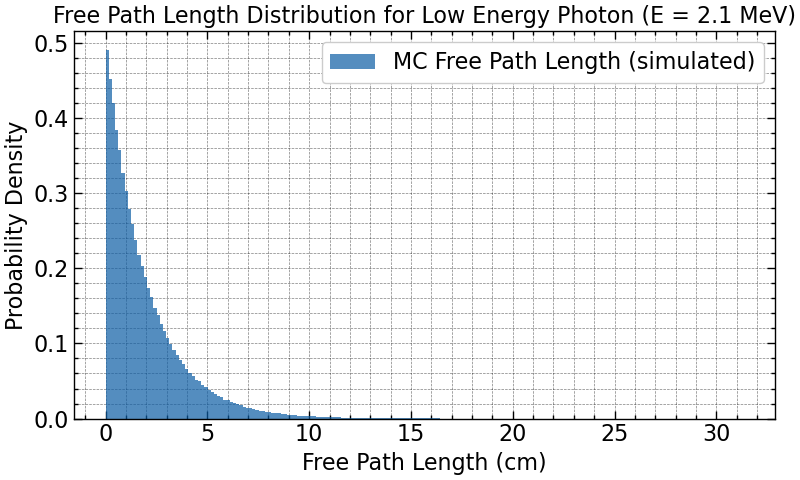

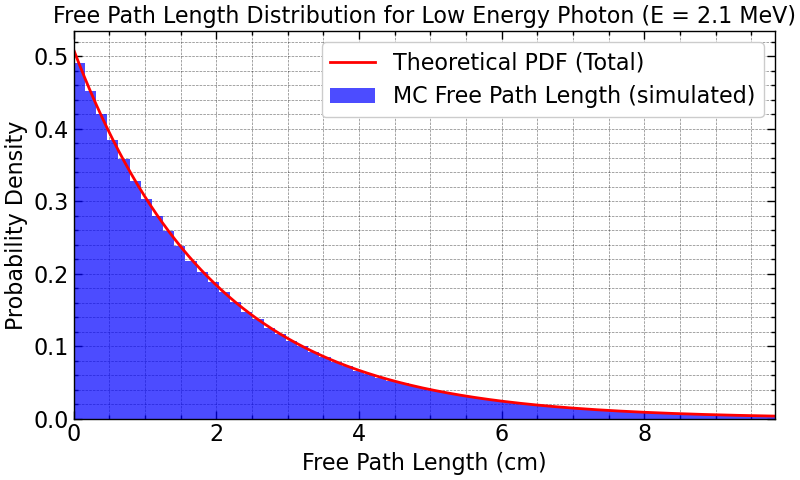

In [162]:
Ngenerated = 10**6
E = 2.1  # MeV
# lets generate many s_free and plot the histogram that represents the free path length distribution - PDF
# PDF = probability density function; PDF = f(x;lac) = lac * exp(-lac*x) - lets check if this is true (code test)
s_free_samples = []

if E < 1.02:
    print(f"\nGenerating free path lengths for low energy photon (E = {E} MeV) using Compton scattering and photoelectric effect.\n\n")
    for _ in range(Ngenerated):
        s_free = FreePathLowEnergy(E, energy_lead, lac_cs_lead, lac_pe_lead)  # Generate free path length
        s_free_samples.append(s_free)   
else:
    print(f"\nGenerating free path lengths for photon with (E = {E} MeV) using Compton scattering, photoelectric effect, and pair production.\n\n")
    for _ in range(Ngenerated):
        s_free = FreePathWithPP(E, energy_lead, lac_cs_lead, lac_pe_lead, lac_pp_lead)
        s_free_samples.append(s_free)

s_free_samples = np.array(s_free_samples)

# Plot histogram of free path lengths
plt.figure(figsize=(8,5))
plt.hist(s_free_samples, bins=200, density=True, alpha=0.7, label='MC Free Path Length (simulated)')
plt.xlabel('Free Path Length (cm)')
plt.ylabel('Probability Density')
plt.title(f'Free Path Length Distribution for Low Energy Photon (E = {E} MeV)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Theoretical PDF for free path length
def theoretical_pdf(s, lac):
    """
    Theoretical PDF for free path length based on the linear attenuation coefficient.
    
    Parameters:
    s : float or np.ndarray
        Free path length (cm)
    lac : float
        Linear attenuation coefficient (cm^-1)
    
    Returns:
    Probability density function value(s) for the given free path length(s).
    """
    return lac * np.exp(-lac * s)

# Calculate the theoretical PDF for free path lengths
lac_cs = interpolate_lac(energy_lead, lac_incoherent_lead, E)  # Compton scattering linear attenuation coefficient
lac_pe = interpolate_lac(energy_lead, lac_photoelectric_lead, E)
lac_pp = 0.0  # Pair production linear attenuation coefficient is zero for low energy photons
if E >= 1.02:
    lac_pp = interpolate_lac(energy_lead, lac_pair_production_nuclear_lead + lac_pair_production_electron_lead, E)  # Pair production linear attenuation coefficient
lac_tot = lac_cs + lac_pe + lac_pp  # Total linear attenuation coefficient

# Theoretical PDF for Compton scattering and photoelectric effect
smax_plot = 5 / lac_tot  # Maximum free path length for plotting (5 times the average free path length)
s_values = np.linspace(0, smax_plot, 1000)  # Range of free path lengths
pdf_cs = theoretical_pdf(s_values, lac_cs)
pdf_pe = theoretical_pdf(s_values, lac_pe)
pdf_tot = theoretical_pdf(s_values, lac_tot)  # Total PDF for low energy photon

# Plot the theoretical PDF for free path lengths
plt.figure(figsize=(8,5))

#plt.plot(s_values, pdf_cs, label='Theoretical PDF (Compton Scattering)', color='orange')
#plt.plot(s_values, pdf_pe, label='Theoretical PDF (Photoelectric Effect)', color='green')
plt.plot(s_values, pdf_tot, label='Theoretical PDF (Total)', color='red')
plt.hist(s_free_samples, bins=200, density=True, alpha=0.7, label='MC Free Path Length (simulated)', color='blue')

plt.xlim(0, smax_plot)  # Set x-axis limit to the maximum free path length
plt.xlabel('Free Path Length (cm)')
plt.ylabel('Probability Density')
plt.title(f'Free Path Length Distribution for Low Energy Photon (E = {E} MeV)')
plt.legend()    
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



---
---
---
---
---
# Last change: 03/09/2025
---
---
---